In [2]:
!pip install hmmlearn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 165.9/165.9 kB 4.2 MB/s eta 0:00:0000:01


In [15]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from hmmlearn.hmm import GaussianHMM
import yfinance as yf

def fetch_data(ticker, start_date, end_date):
    data = yf.download(ticker, start=start_date, end=end_date)
    return data

# Fetching S&P500 ETF data ('SPY') from Yahoo Finance
start_date = "2007-01-01"
end_date = "2020-04-01"
ticker = "SPY"

data = fetch_data(ticker, start_date, end_date)
data.columns = [col[0] for col in data.columns]
data['log_returns'] = np.log((data['Close'] + 1e-8) / (data['Close'].shift(1) + 1e-8))
data['volatility'] = data['log_returns'].rolling(window=10).std()
data.dropna(inplace = True)

print(data.head())

/tmp/ipykernel_36/1339319791.py:8: FutureWarning: YF.download() has changed argument auto_adjust default to True
  data = yf.download(ticker, start=start_date, end=end_date)
[*********************100%***********************]  1 of 1 completed

                 Close        High         Low        Open    Volume  \
Date                                                                   
2007-01-18  100.792336  101.301460  100.629702  101.237822  68177300   
2007-01-19  100.990326  101.188318  100.735764  100.792323  56973000   
2007-01-22  100.679184  101.188308  100.360973  101.167096  60253600   
2007-01-23  100.976189  101.174180  100.452919  100.594340  54064400   
2007-01-24  101.789368  101.810580  101.053972  101.096397  55834700   

            log_returns  volatility  
Date                                 
2007-01-18    -0.003362    0.004553  
2007-01-19     0.001962    0.004549  
2007-01-22    -0.003086    0.003670  
2007-01-23     0.002946    0.003538  
2007-01-24     0.008021    0.004059  



/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


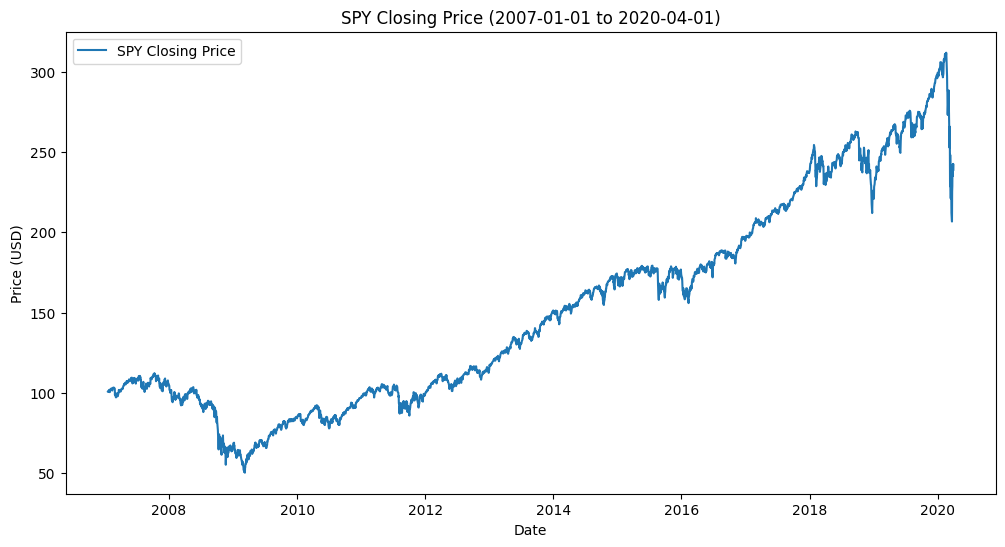

In [16]:
# Plotting the closing price
plt.figure(figsize=(12, 6))
plt.plot(data['Close'], label=f'{ticker} Closing Price')
plt.title(f'{ticker} Closing Price ({start_date} to {end_date})')
plt.xlabel('Date')
plt.ylabel('Price (USD)')
plt.legend()
plt.show()

In [17]:
split_date = '2017-09-01'

train_data = data[ : split_date].copy()
test_data = data[split_date : ].copy()

In [18]:
from sklearn.preprocessing import StandardScaler

def train_hmm(data, n_states=3):
    # Extract features (Daily Return and Volatility)
    features = data[['log_returns', 'volatility']].values

    # Standardize features
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)

    # Train Gaussian HMM
    hmm_model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
    hmm_model.fit(features_scaled)

    return hmm_model, features_scaled, scaler

In [31]:
n_states = 3
hmm_model, train_features_scaled, scaler = train_hmm(train_data, n_states = 3)

In [32]:
# Analyze Model Parameters
print("HMM Parameters:")
print("Transition Matrix (A):")
print(hmm_model.transmat_)
print("Means (μ):")
print(hmm_model.means_)
print("Covariances (σ^2):")
print(hmm_model.covars_)
print("Initial State Probabilities (π):")
print(hmm_model.startprob_)

# Evaluate In-Sample Log-Likelihood
in_sample_log_likelihood = hmm_model.score(train_features_scaled)
print(f"In-Sample Log-Likelihood: {in_sample_log_likelihood}")

HMM Parameters:
Transition Matrix (A):
[[9.71183214e-01 2.77991455e-02 1.01764005e-03]
 [3.31338825e-02 9.60112029e-01 6.75408901e-03]
 [1.05166818e-19 2.22128771e-02 9.77787123e-01]]
Means (μ):
[[ 0.03094038 -0.62609329]
 [-0.00704145  0.07513552]
 [-0.08006796  1.80901121]]
Covariances (σ^2):
[[[1.79511320e-01 1.65250483e-03]
  [1.65250483e-03 3.53951603e-02]]

 [[7.35570505e-01 1.77824328e-02]
  [1.77824328e-02 8.10374535e-02]]

 [[4.37838654e+00 5.59152482e-02]
  [5.59152482e-02 2.13485814e+00]]]
Initial State Probabilities (π):
[1.00000000e+000 1.27983948e-059 3.42249388e-305]
In-Sample Log-Likelihood: -3718.269520733284


In [33]:
def validate_hmm(hmm_model, data, scaler):
    """
    Validate the HMM on the test dataset.
    
    Args:
        hmm_model: Trained HMM model.
        data (DataFrame): Test data for validation.
        scaler: StandardScaler used for scaling the training data.
        
    Returns:
        DataFrame: Test data with predicted regimes.
        float: Log-likelihood of the test data.
    """
    # Extract and scale features
    features = data[['log_returns', 'volatility']].values
    features_scaled = scaler.transform(features)

    # Predict regimes
    regimes = hmm_model.predict(features_scaled)

    # Compute log-likelihood
    log_likelihood = hmm_model.score(features_scaled)

    # Add predicted regimes to the test data
    validated_data = data.copy()
    validated_data['regime'] = regimes

    return validated_data, log_likelihood

# Validate the HMM on test data
validated_test_data, out_sample_log_likelihood = validate_hmm(hmm_model, test_data, scaler)

# Display results
print(f"Out-of-Sample Log-Likelihood: {out_sample_log_likelihood}")
print(validated_test_data[['log_returns', 'volatility', 'regime']].head())

Out-of-Sample Log-Likelihood: -843.1714150421084
            log_returns  volatility  regime
Date                                       
2017-09-01     0.001413    0.004089       0
2017-09-05    -0.007208    0.005043       0
2017-09-06     0.003408    0.004020       0
2017-09-07    -0.000122    0.003760       0
2017-09-08    -0.001175    0.003665       0


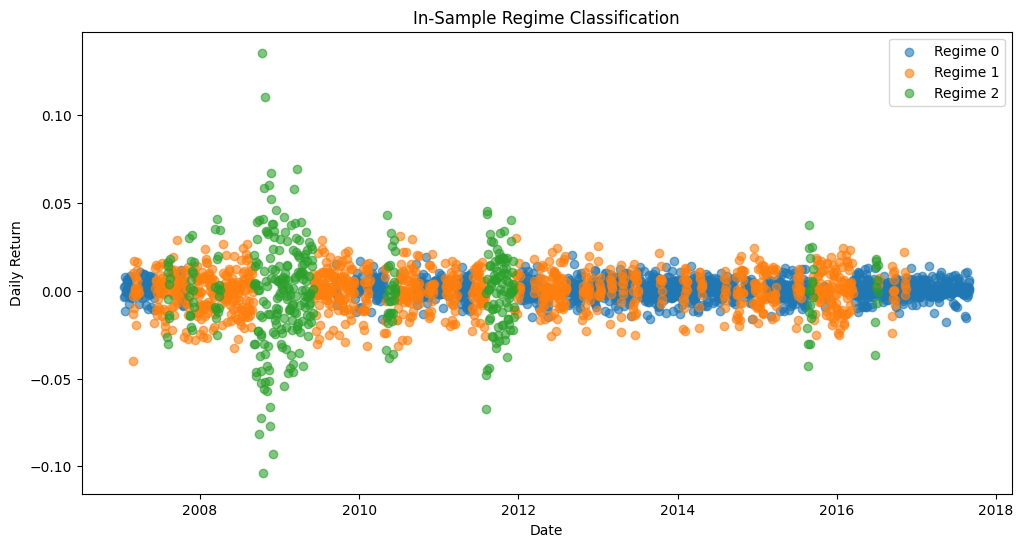

In [34]:
# Add predicted regimes to training data
train_data = train_data.copy()
train_data['regime'] = hmm_model.predict(train_features_scaled)

# Plot training data regimes
plt.figure(figsize=(12, 6))
for regime in range(n_states):
    regime_data = train_data[train_data['regime'] == regime]
    plt.scatter(regime_data.index, regime_data['log_returns'], label=f"Regime {regime}", alpha=0.6)

plt.title("In-Sample Regime Classification")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

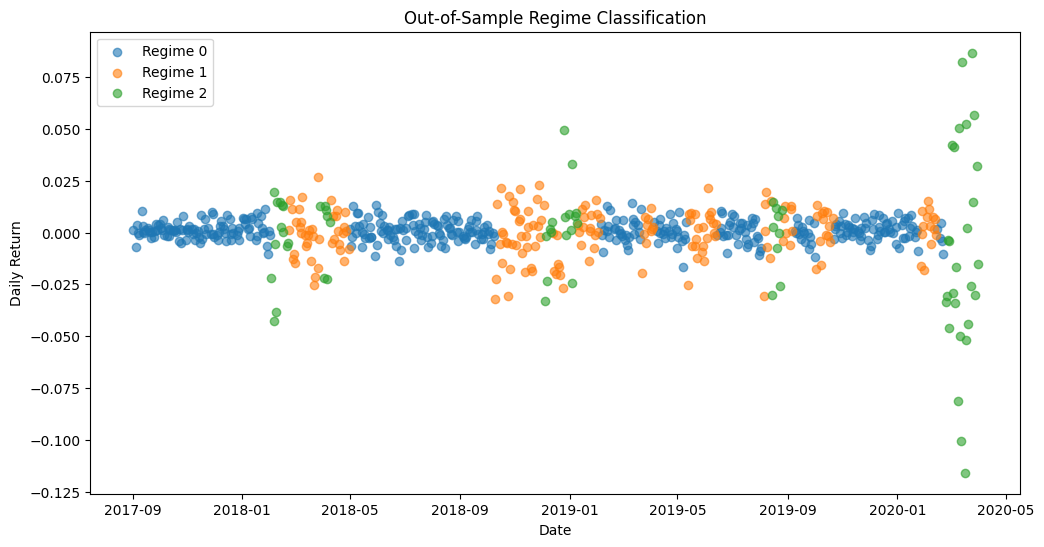

In [36]:
# Plot test data regimes
plt.figure(figsize=(12, 6))
for regime in range(n_states):
    regime_data = validated_test_data[validated_test_data['regime'] == regime]
    plt.scatter(regime_data.index, regime_data['log_returns'], label=f"Regime {regime}", alpha=0.6)

plt.title("Out-of-Sample Regime Classification")
plt.xlabel("Date")
plt.ylabel("Daily Return")
plt.legend()
plt.show()

In [37]:
# Compute statistics for the training data
train_regime_stats = train_data.groupby('regime')[['log_returns', 'volatility']].mean()
print("In-Sample Regime Statistics (Training Data):")
print(train_regime_stats)

In-Sample Regime Statistics (Training Data):
        log_returns  volatility
regime                         
0          0.000700    0.005270
1          0.000202    0.010839
2         -0.000801    0.024623


In [39]:
# Compute statistics for the training data
test_regime_stats = validated_test_data.groupby('regime')[['log_returns', 'volatility']].mean()
print("Out-Sample Regime Statistics (Testing Data):")
print(test_regime_stats)

Out-Sample Regime Statistics (Testing Data):
        log_returns  volatility
regime                         
0          0.000942    0.004621
1         -0.000114    0.011052
2         -0.003604    0.028639


In [40]:
# Combine train and test data
full_data = pd.concat([train_data, validated_test_data])

# Ensure regimes are classified for the entire dataset
features = full_data[['log_returns', 'volatility']].values
features_scaled = scaler.transform(features)
full_data['regime'] = hmm_model.predict(features_scaled)

In [41]:
from sklearn.metrics import silhouette_score 

# Ensure features are scaled for the entire dataset (used in 3-state model)
features_scaled_3 = scaler.transform(full_data[['log_returns', 'volatility']].values)

# Compute silhouette score for 3-state model
silhouette_score_3 = silhouette_score(features_scaled_3, full_data['regime'])
print(f"Silhouette Score (3-State Model): {silhouette_score_3}")

Silhouette Score (3-State Model): 0.23511850703827025


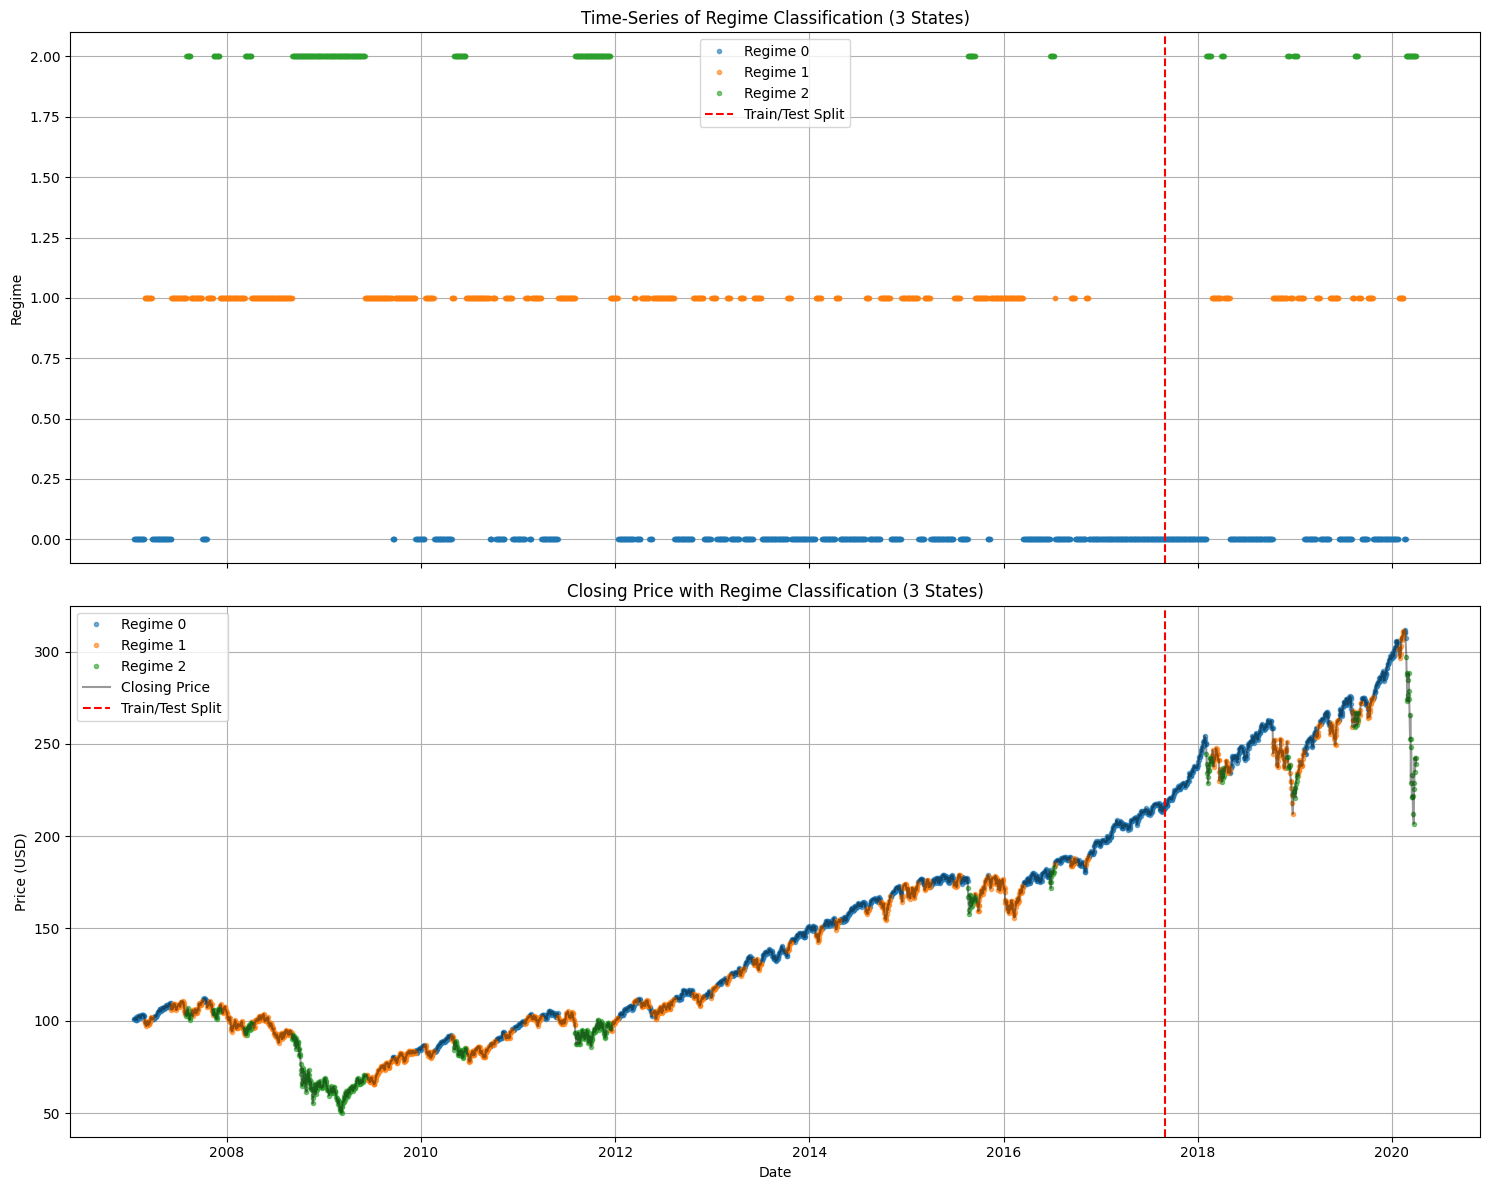

In [45]:
import matplotlib.pyplot as plt

# Create the combined figure
fig, axes = plt.subplots(2, 1, figsize=(15, 12), sharex=True)

# Plot 1: Time-Series of Regime Classification
for regime in range(3):
    regime_data = full_data[full_data['regime'] == regime]
    axes[0].plot(regime_data.index, regime_data['regime'], '.', label=f'Regime {regime}', alpha=0.6)
axes[0].axvline(pd.Timestamp(split_date), color='red', linestyle='--', label="Train/Test Split")
axes[0].set_title("Time-Series of Regime Classification (3 States)")
axes[0].set_ylabel("Regime")
axes[0].legend()
axes[0].grid(True)

# Plot 2: Closing Price with Regime Classification
for regime in range(3):
    regime_data = full_data[full_data['regime'] == regime]
    axes[1].plot(regime_data.index, regime_data['Close'], '.', label=f'Regime {regime}', alpha=0.6)
axes[1].plot(full_data.index, full_data['Close'], color='black', alpha=0.4, label="Closing Price")
axes[1].axvline(pd.Timestamp(split_date), color='red', linestyle='--', label="Train/Test Split")
axes[1].set_title("Closing Price with Regime Classification (3 States)")
axes[1].set_xlabel("Date")
axes[1].set_ylabel("Price (USD)")
axes[1].legend()
axes[1].grid(True)

# Display the combined plot
plt.tight_layout()
plt.show()

/tmp/ipykernel_36/363167201.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(ticker, start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_36/363167201.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(ticker, start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
/tmp/ipykernel_36/363167201.py:20: FutureWarning: YF.download() has changed argument auto_adjust default to True
  return yf.download(ticker, start=start, end=end)['Close']
[*********************100%***********************]  1 of 1 completed
/usr/local/lib/python3.11/dist-packages/pandas/core/internals/blocks.py:393: RuntimeWarning: invalid value encountered in log
  result = func(self.values, **kwargs)
/usr/local/lib/python3.11/dist-packages/sklearn/base.py:432: UserWarning: X has feature names, but StandardSc

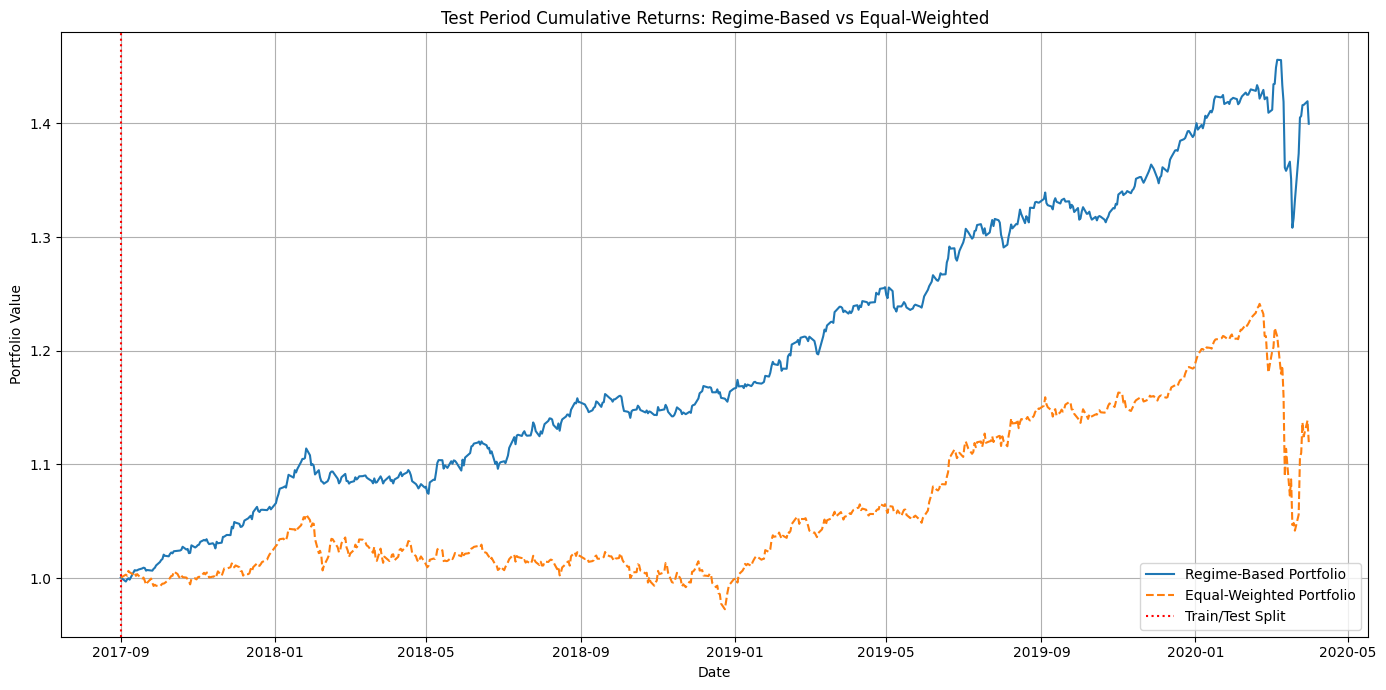

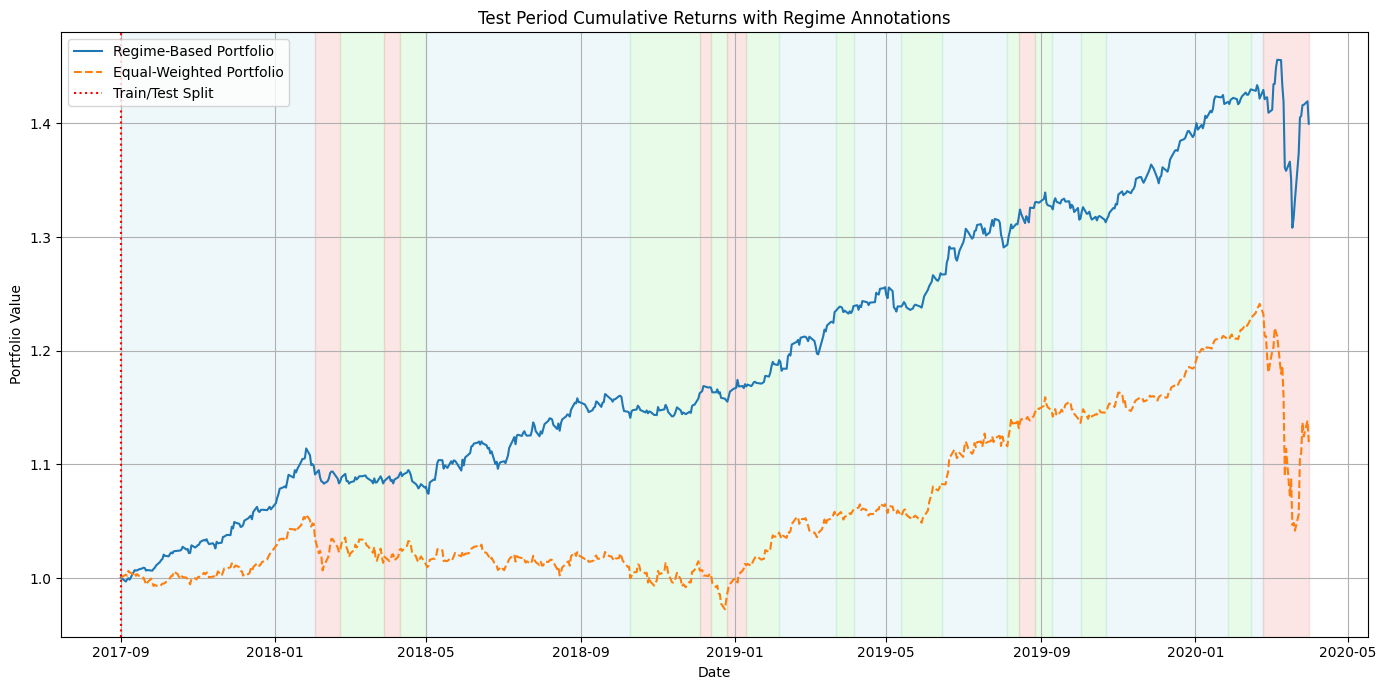


Performance: Regime-Based Portfolio (Test Data)
{'Annual Return': 0.1331291993216048,
 'Annual Volatility': 0.06778972044488543,
 'Max Drawdown': -0.10149425083271392,
 'Sharpe Ratio': 1.0787653178339995,
 'Sortino Ratio': 1.2366440646661523}

Performance: Equal-Weighted Benchmark (Test Data)
{'Annual Return': 0.048015769304241396,
 'Annual Volatility': 0.08993734502784423,
 'Max Drawdown': -0.16078089177300506,
 'Sharpe Ratio': -0.13325088362401996,
 'Sortino Ratio': -0.13505257083596348}

Portfolio Weights by Regime (Trained on Train Data):

Regime 0:
  SPY: 70.34%
  GLD: 4.31%
  AGG: 25.36%

Regime 1:
  SPY: 14.03%
  GLD: 25.09%
  AGG: 60.88%

Regime 2:
  SPY: 0.00%
  GLD: 37.90%
  AGG: 62.10%


In [67]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from hmmlearn.hmm import GaussianHMM
from sklearn.preprocessing import StandardScaler
from pprint import pprint

# --------------------------- PARAMETERS ---------------------------

start_date = "2007-01-01"
end_date = "2020-04-01"
split_date = "2017-09-01"
tickers = ['SPY', 'GLD', 'AGG']
risk_free_rate_annual = 0.06

# --------------------------- FETCH DATA ---------------------------

def fetch_data(ticker, start, end):
    return yf.download(ticker, start=start, end=end)['Close']

prices = pd.concat([fetch_data(t, start_date, end_date) for t in tickers], axis=1)
prices.columns = tickers

# --------------------------- LOG RETURNS ---------------------------

log_returns = np.log(prices / prices.shift(1))
log_returns.dropna(inplace=True)

# --------------------------- VOLATILITY FEATURES ---------------------------

volatility = log_returns.rolling(window=10).std()
features_df = log_returns.copy()
features_df.columns = [f'{col}_log_return' for col in log_returns.columns]
for col in tickers:
    features_df[f'{col}_volatility'] = volatility[col]

features_df.dropna(inplace=True)

# --------------------------- HMM ON SPY ---------------------------

def train_hmm(data, n_states=3):
    features = data[['SPY_log_return', 'SPY_volatility']].dropna().values
    scaler = StandardScaler()
    features_scaled = scaler.fit_transform(features)
    model = GaussianHMM(n_components=n_states, covariance_type="full", n_iter=1000, random_state=42)
    model.fit(features_scaled)
    return model, scaler

train_data = features_df.loc[:split_date].copy()
hmm_model, scaler = train_hmm(train_data, n_states=3)

# Predict regimes for full dataset
features_scaled_full = scaler.transform(features_df[['SPY_log_return', 'SPY_volatility']])
features_df['regime'] = hmm_model.predict(features_scaled_full)

# --------------------------- CALIBRATE WEIGHTS ON TRAIN DATA ONLY ---------------------------

train_data = features_df.loc[:split_date].copy()
train_data['regime'] = features_df['regime'].loc[:split_date]

def compute_weights_by_regime(data, tickers, regime_col='regime'):
    weights = {}
    for regime in sorted(data[regime_col].unique()):
        sub = data[data[regime_col] == regime][[f'{t}_log_return' for t in tickers]]
        mean_returns = sub.mean()
        vol = sub.std()
        risk_adj = mean_returns / vol
        positive_risk_adj = risk_adj.clip(lower=0)
        total = positive_risk_adj.sum()
        if total > 0:
            normalized_weights = positive_risk_adj / total
        else:
            normalized_weights = pd.Series([1/len(tickers)] * len(tickers), index=[f'{t}_log_return' for t in tickers])
        weights[regime] = normalized_weights
    return weights

weights_by_regime = compute_weights_by_regime(train_data, tickers)

# --------------------------- APPLY WEIGHTS ON TEST DATA ---------------------------

def apply_weights(data, weights_by_regime, tickers):
    port_returns = []
    for idx, row in data.iterrows():
        regime = row['regime']
        asset_returns = np.array([row[f'{t}_log_return'] for t in tickers])
        original_weights = weights_by_regime.get(regime, pd.Series([1/len(tickers)] * len(tickers), index=[f'{t}_log_return' for t in tickers]))
        positive_weights = original_weights.clip(lower=0)
        total = positive_weights.sum()
        if total > 0:
            normalized_weights = positive_weights / total
        else:
            normalized_weights = pd.Series([1/len(tickers)] * len(tickers), index=[f'{t}_log_return' for t in tickers])
        port_return = np.dot(normalized_weights.values, asset_returns)
        port_returns.append(port_return)
    return pd.Series(port_returns, index=data.index)

test_data = features_df.loc[split_date:].copy()
test_data['regime'] = features_df['regime'].loc[split_date:]

regime_based_returns = apply_weights(test_data, weights_by_regime, tickers)

# Benchmark equal-weighted returns on test data
equal_weights = np.array([1/len(tickers)] * len(tickers))
equal_weighted_returns = log_returns[tickers].loc[test_data.index].dot(equal_weights)

# --------------------------- PERFORMANCE METRICS ---------------------------

def compute_metrics(returns, rf=0.06):
    ann_return = returns.mean() * 252
    ann_vol = returns.std() * np.sqrt(252)
    sharpe = (ann_return - rf) / ann_vol
    downside = returns[returns < 0]
    sortino = (ann_return - rf) / (downside.std() * np.sqrt(252))
    cum_returns = (1 + returns).cumprod()
    peak = cum_returns.cummax()
    drawdown = (cum_returns - peak) / peak
    max_drawdown = drawdown.min()
    return {
        'Annual Return': ann_return,
        'Annual Volatility': ann_vol,
        'Sharpe Ratio': sharpe,
        'Sortino Ratio': sortino,
        'Max Drawdown': max_drawdown
    }

regime_metrics = compute_metrics(regime_based_returns, rf=risk_free_rate_annual)
benchmark_metrics = compute_metrics(equal_weighted_returns, rf=risk_free_rate_annual)

# --------------------------- PLOTTING ---------------------------

# Cumulative returns for test period
cum_regime = (1 + regime_based_returns).cumprod()
cum_benchmark = (1 + equal_weighted_returns).cumprod()

plt.figure(figsize=(14, 7))
plt.plot(cum_regime, label='Regime-Based Portfolio')
plt.plot(cum_benchmark, label='Equal-Weighted Portfolio', linestyle='--')
plt.title("Test Period Cumulative Returns: Regime-Based vs Equal-Weighted")
plt.xlabel("Date")
plt.ylabel("Portfolio Value")
plt.axvline(pd.Timestamp(split_date), color='red', linestyle=':', label='Train/Test Split')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# --------------------------- PLOT WITH REGIME ANNOTATIONS ---------------------------

# Assign consistent colors to regimes
regime_colors = {
    0: 'lightblue',
    1: 'lightgreen',
    2: 'lightcoral'
}

fig, ax = plt.subplots(figsize=(14, 7))

# Plot cumulative returns for test period
ax.plot(cum_regime, label='Regime-Based Portfolio')
ax.plot(cum_benchmark, label='Equal-Weighted Portfolio', linestyle='--')

# Highlight regimes with colored background spans
prev_regime = None
start_idx = None
test_regimes = test_data['regime']

for i in range(len(test_data)):
    date = test_data.index[i]
    regime = test_regimes.iloc[i]

    if regime != prev_regime:
        if start_idx is not None:
            ax.axvspan(test_data.index[start_idx], date, color=regime_colors[prev_regime], alpha=0.2)
        start_idx = i
        prev_regime = regime

# Add final span for the last regime
if start_idx is not None:
    ax.axvspan(test_data.index[start_idx], test_data.index[-1], color=regime_colors[prev_regime], alpha=0.2)

# Vertical line for train/test split
ax.axvline(pd.Timestamp(split_date), color='red', linestyle=':', label='Train/Test Split')

# Plot formatting
ax.set_title("Test Period Cumulative Returns with Regime Annotations")
ax.set_xlabel("Date")
ax.set_ylabel("Portfolio Value")
ax.legend()
ax.grid(True)
plt.tight_layout()
plt.show()


# --------------------------- OUTPUT METRICS ---------------------------

print('\nPerformance: Regime-Based Portfolio (Test Data)')
pprint(regime_metrics)

print('\nPerformance: Equal-Weighted Benchmark (Test Data)')
pprint(benchmark_metrics)

print("\nPortfolio Weights by Regime (Trained on Train Data):")
for regime, weights in weights_by_regime.items():
    print(f"\nRegime {regime}:")
    for asset, weight in weights.items():
        print(f"  {asset.replace('_log_return', '')}: {weight:.2%}")
